In [1]:
import os
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.io as pio 
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.utils import resample 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, auc, roc_curve

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, LabelEncoder

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
warnings.filterwarnings('ignore')

In [3]:
sns.set_style('whitegrid', {'axes.grid' :False})
pio.templates.default = 'plotly_white'

In [4]:
dset = pd.read_csv('/kaggle/input/crop-data2k/Crop_recommendation.csv')

# **EDA**

In [5]:
dset.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


In [6]:
dset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [7]:
dset.isnull().sum()

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

**Correlation Matrix**

<Axes: >

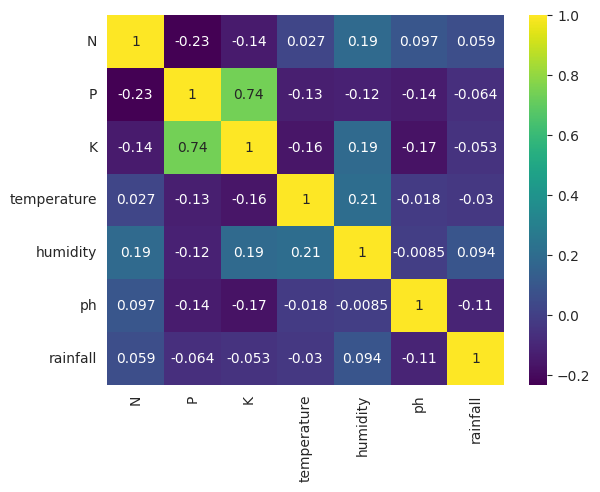

In [8]:
corr = dset.iloc[:, :-1].corr()
fig, ax = plt.subplots()
sns.heatmap(corr, annot=True, ax=ax, cmap='viridis')

**Pair Plot(s)**

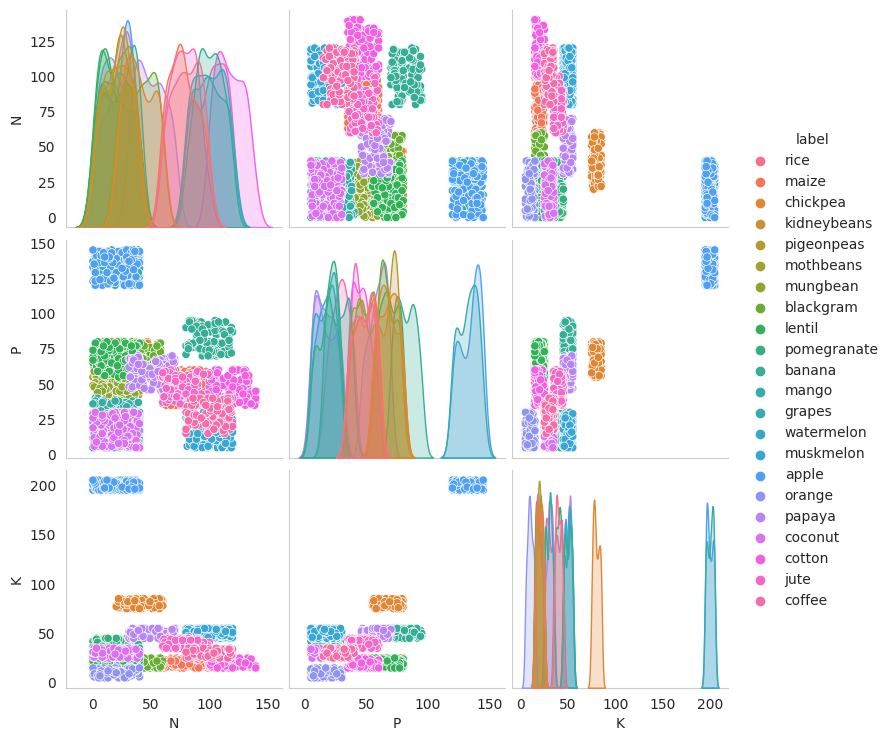

In [9]:
important_features = ['N', 'P', 'K']
fig2 = sns.pairplot(dset[important_features + ['label']], hue='label')

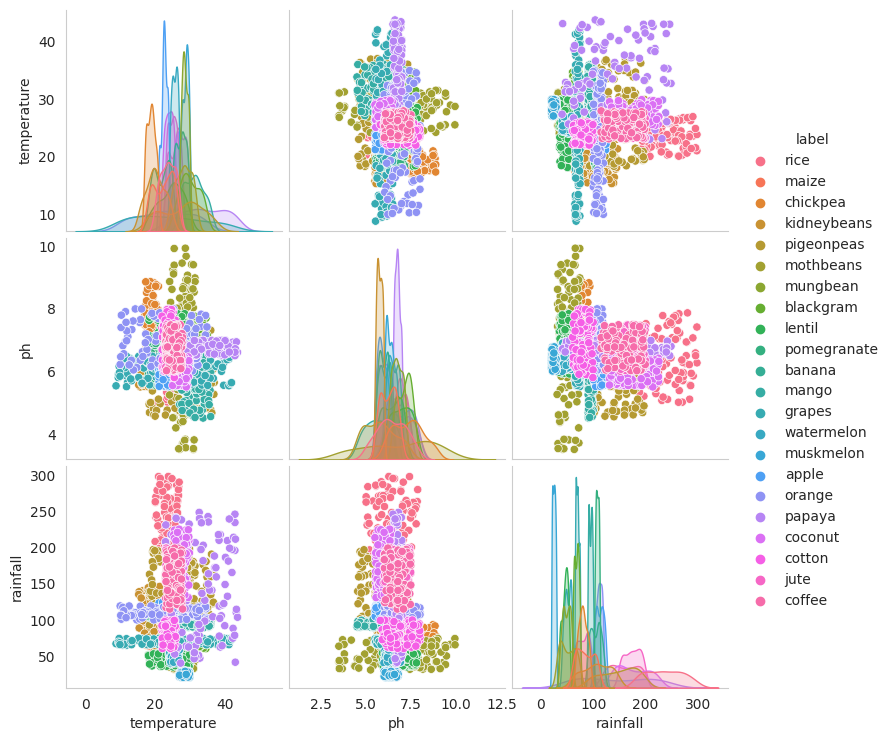

In [10]:
important_features_ = ['temperature', 'ph', 'rainfall']
fig2_ = sns.pairplot(dset[important_features_ + ['label']], hue='label')

**Bar Plot**

In [11]:
fig4 = px.bar(dset, x='humidity', y='label', color='label', title='Humidity vs. Label')
fig4

**Distribution of each feature**

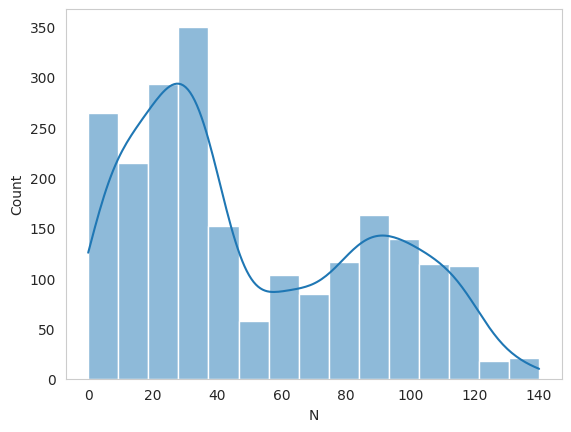

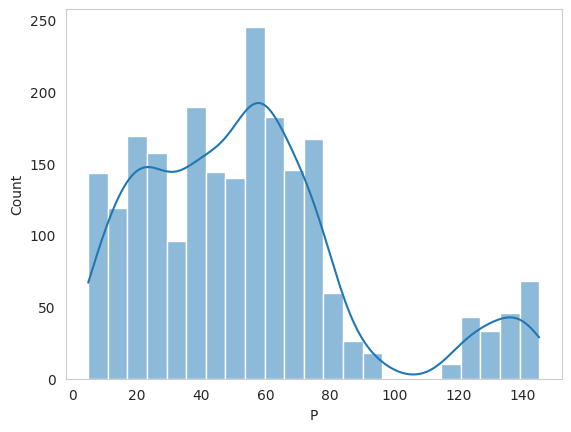

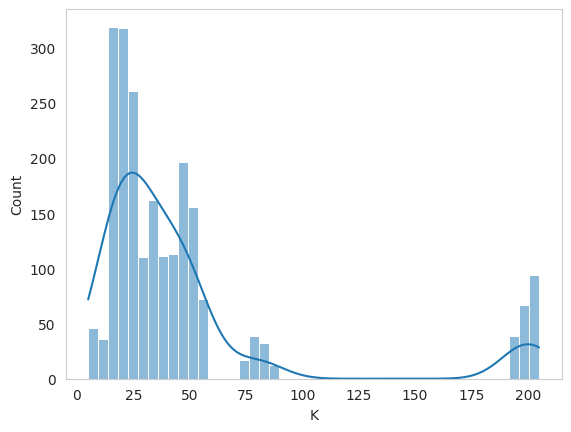

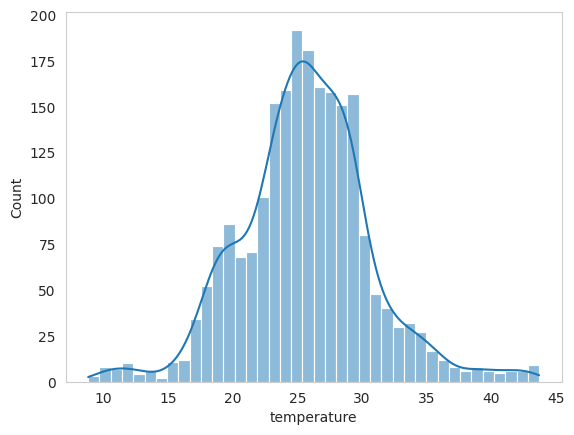

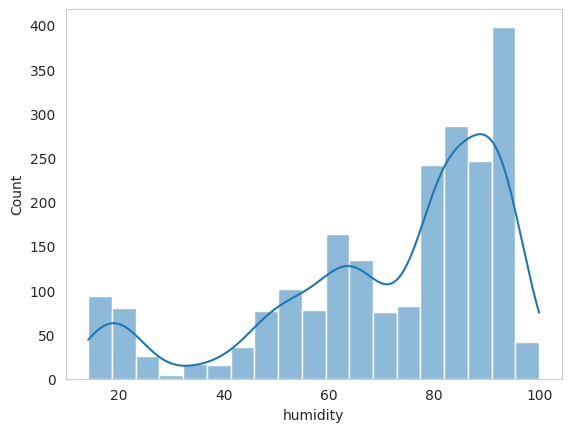

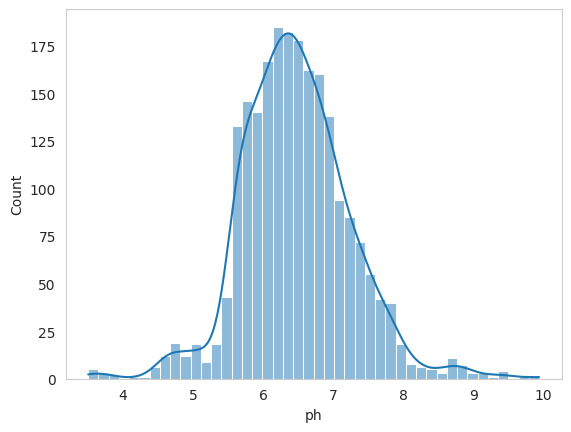

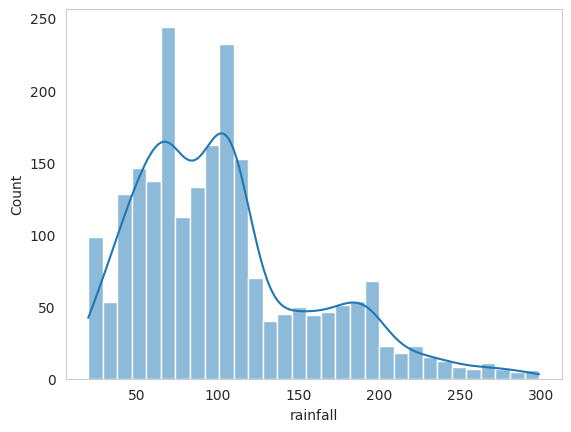

In [12]:
for col in dset.columns[:-1]:  
    fig3, ax3 = plt.subplots()
    sns.histplot(dset[col], kde=True, ax=ax3)

# **Data Analysis & Preprocessing**

In [13]:
def explore_data(df):
    print('Number of INSTANCES and ATTRIBUTES:', df.shape)
    print('Dataset COLUMNS:', df.columns)

In [14]:
explore_data(dset)

Number of INSTANCES and ATTRIBUTES: (2200, 8)
Dataset COLUMNS: Index(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label'], dtype='object')


In [15]:
def checking_removing_duplicates(df):
    count_dups = df.duplicated().sum()
    print('Number of DUPLICATES:', count_dups)
    if count_dups >= 1:
        df.drop_duplicates(inplace=True)
        print('DUPLICATE values removed!')
    else:
        print('No DUPLICATE values!')

In [16]:
checking_removing_duplicates(dset)

Number of DUPLICATES: 0
No DUPLICATE values!


In [17]:
def read_in_and_split_data(data, target):
    X = data.drop(target, axis=1)
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    return X_train, X_test, y_train, y_test

# **ML Models**

In [18]:
def GetModel():
    Models = []
    Models.append(('LR'   , LogisticRegression()))
    Models.append(('LDA'  , LinearDiscriminantAnalysis()))
    Models.append(('KNN'  , KNeighborsClassifier()))
    Models.append(('DTreeC' , DecisionTreeClassifier()))
    Models.append(('NB'   , GaussianNB()))
    Models.append(('SVM'  , SVC(probability=True)))

    return Models

In [19]:
# def ensemblemodels():
#     ensembles = []
#     ensembles.append(('AB'   , AdaBoostClassifier()))
#     ensembles.append(('GBM'  , GradientBoostingClassifier()))
#     ensembles.append(('RF'   , RandomForestClassifier()))
#     ensembles.append(( 'Bagging' , BaggingClassifier()))
#     ensembles.append(('ET', ExtraTreesClassifier()))
    
#     return ensembles

# **Scaling & Pipelines**

In [20]:
# def NormalizedModel(nameOfScaler):
#     if nameOfScaler == 'standard':
#         scaler = StandardScaler()
#     elif nameOfScaler == 'minmax':
#         scaler = MinMaxScaler()
#     elif nameOfScaler == 'normalizer':
#         scaler = Normalizer()
#     elif nameOfScaler == 'binarizer':
#         scaler = Binarizer()

#     pipelines = []
#     pipelines.append((nameOfScaler+'LR', Pipeline([('Scaler', scaler), ('LR', LogisticRegression())])))
#     pipelines.append((nameOfScaler+'LDA' , Pipeline([('Scaler', scaler),('LDA' , LinearDiscriminantAnalysis())])))
#     pipelines.append((nameOfScaler+'KNN' , Pipeline([('Scaler', scaler),('KNN' , KNeighborsClassifier())])))
#     pipelines.append((nameOfScaler+'CART', Pipeline([('Scaler', scaler),('CART', DecisionTreeClassifier())])))
#     pipelines.append((nameOfScaler+'NB'  , Pipeline([('Scaler', scaler),('NB'  , GaussianNB())])))
#     pipelines.append((nameOfScaler+'SVM' , Pipeline([('Scaler', scaler),('SVM' , SVC())])))
#     pipelines.append((nameOfScaler+'AB'  , Pipeline([('Scaler', scaler),('AB'  , AdaBoostClassifier())])))
#     pipelines.append((nameOfScaler+'GBM' , Pipeline([('Scaler', scaler),('GMB' , GradientBoostingClassifier())])))
#     pipelines.append((nameOfScaler+'RF'  , Pipeline([('Scaler', scaler),('RF'  , RandomForestClassifier())])))
#     pipelines.append((nameOfScaler+'ET'  , Pipeline([('Scaler', scaler),('ET'  , ExtraTreesClassifier())])))

#     return pipelines

**Function for fitting the models**

In [21]:
def fit_model(X_train, y_train, Models):
    num_folds = 10
    scoring = 'accuracy'

    results = []
    names = []

    for name, model in Models:
        kfold = KFold(n_splits=num_folds, shuffle=True, random_state=0)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        
        results.append(cv_results)
        names.append(name)
        msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())

    return names, results

# **Evaluation**

In [22]:
def classification_metrics(model, conf_matrix):
    print(f"Training Accuracy Score: {model.score(X_train, y_train) * 100:.1f}%")
    print(f"Validation Accuracy Score: {model.score(X_test, y_test) * 100:.1f}%")
    
    fig,ax = plt.subplots(figsize=(8,6))
    sns.heatmap(pd.DataFrame(conf_matrix), annot = True, cmap = 'YlGnBu',fmt = 'g')
    ax.xaxis.set_label_position('top')
    plt.tight_layout()
    plt.title('Confusion Matrix', fontsize=20, y=1.1)
    plt.ylabel('Actual label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)
    plt.show()
    
    print(classification_report(y_test, y_pred1))

# **Outlier Detection & Removal**

In [23]:
numerical_cols = dset.select_dtypes(include=[np.number])

q1 = numerical_cols.quantile(0.25)
q3 = numerical_cols.quantile(0.75)
inter_q_range = q3 - q1
outlier_mask = ~((numerical_cols < (q1 - 1.5 * inter_q_range)) | (numerical_cols > (q3 + 1.5 * inter_q_range)))

outlier_data = dset[outlier_mask.all(axis=1)]

# **Fitting & Predicting**

*GaussianNB*

Training Accuracy Score: 99.5%
Validation Accuracy Score: 99.3%


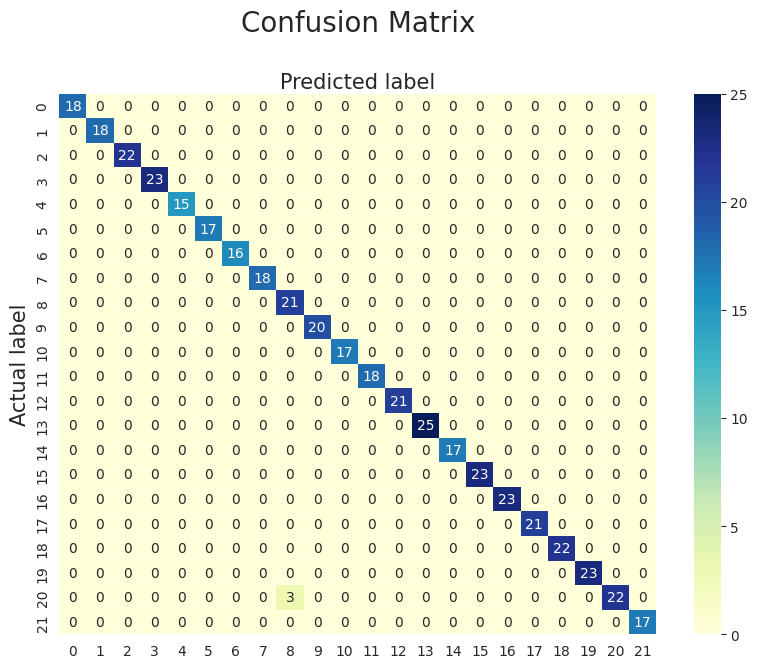

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        18
      banana       1.00      1.00      1.00        18
   blackgram       1.00      1.00      1.00        22
    chickpea       1.00      1.00      1.00        23
     coconut       1.00      1.00      1.00        15
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        16
      grapes       1.00      1.00      1.00        18
        jute       0.88      1.00      0.93        21
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      1.00      1.00        17
       maize       1.00      1.00      1.00        18
       mango       1.00      1.00      1.00        21
   mothbeans       1.00      1.00      1.00        25
    mungbean       1.00      1.00      1.00        17
   muskmelon       1.00      1.00      1.00        23
      orange       1.00      1.00      1.00        23
      papaya       1.00    

In [24]:
target = 'label'
X_train, X_test, y_train, y_test = read_in_and_split_data(dset, target)

pipeline1 = make_pipeline(StandardScaler(), GaussianNB())
model1 = pipeline1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)
matrix1 = confusion_matrix(y_test, y_pred1)
classification_metrics(pipeline1, matrix1)

*SVC*

Training Accuracy Score: 98.8%
Validation Accuracy Score: 97.7%


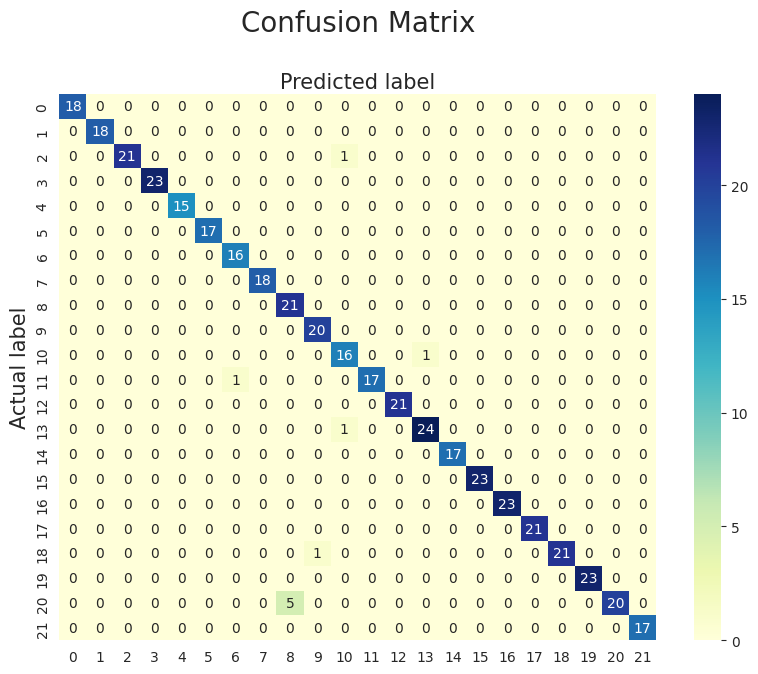

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        18
      banana       1.00      1.00      1.00        18
   blackgram       1.00      1.00      1.00        22
    chickpea       1.00      1.00      1.00        23
     coconut       1.00      1.00      1.00        15
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        16
      grapes       1.00      1.00      1.00        18
        jute       0.88      1.00      0.93        21
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      1.00      1.00        17
       maize       1.00      1.00      1.00        18
       mango       1.00      1.00      1.00        21
   mothbeans       1.00      1.00      1.00        25
    mungbean       1.00      1.00      1.00        17
   muskmelon       1.00      1.00      1.00        23
      orange       1.00      1.00      1.00        23
      papaya       1.00    

In [25]:
target = 'label'
X_train, X_test, y_train, y_test = read_in_and_split_data(dset, target)

pipeline2 = make_pipeline(StandardScaler(), SVC())
model2 = pipeline2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
matrix2 = confusion_matrix(y_test, y_pred2)
classification_metrics(pipeline2, matrix2)

*DecisionTreeClassifier*

Training Accuracy Score: 100.0%
Validation Accuracy Score: 99.1%


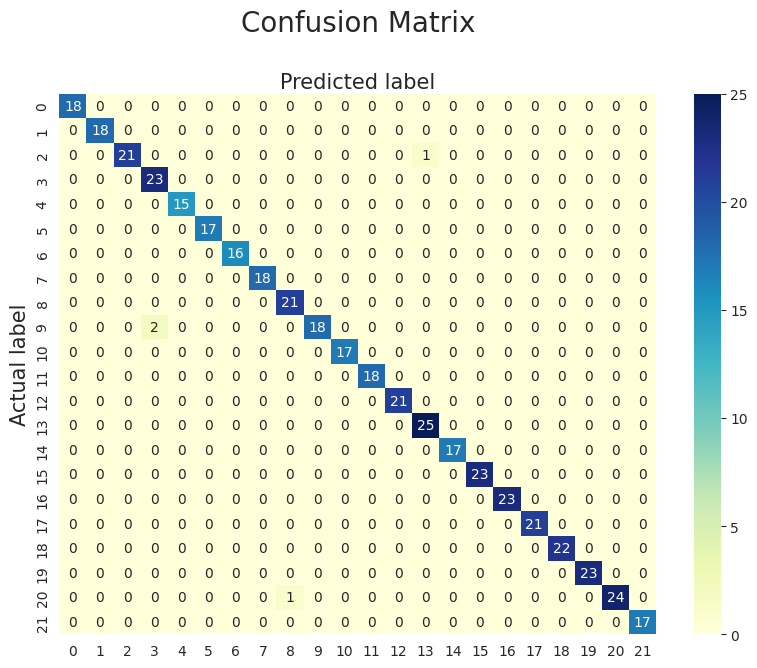

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        18
      banana       1.00      1.00      1.00        18
   blackgram       1.00      1.00      1.00        22
    chickpea       1.00      1.00      1.00        23
     coconut       1.00      1.00      1.00        15
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        16
      grapes       1.00      1.00      1.00        18
        jute       0.88      1.00      0.93        21
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      1.00      1.00        17
       maize       1.00      1.00      1.00        18
       mango       1.00      1.00      1.00        21
   mothbeans       1.00      1.00      1.00        25
    mungbean       1.00      1.00      1.00        17
   muskmelon       1.00      1.00      1.00        23
      orange       1.00      1.00      1.00        23
      papaya       1.00    

In [26]:
target = 'label'
X_train, X_test, y_train, y_test = read_in_and_split_data(dset, target)

pipeline3 = make_pipeline(StandardScaler(), DecisionTreeClassifier())
model3 = pipeline3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)
matrix3 = confusion_matrix(y_test, y_pred3)
classification_metrics(pipeline3, matrix3)

*LogisticRegression*

Training Accuracy Score: 97.5%
Validation Accuracy Score: 96.4%


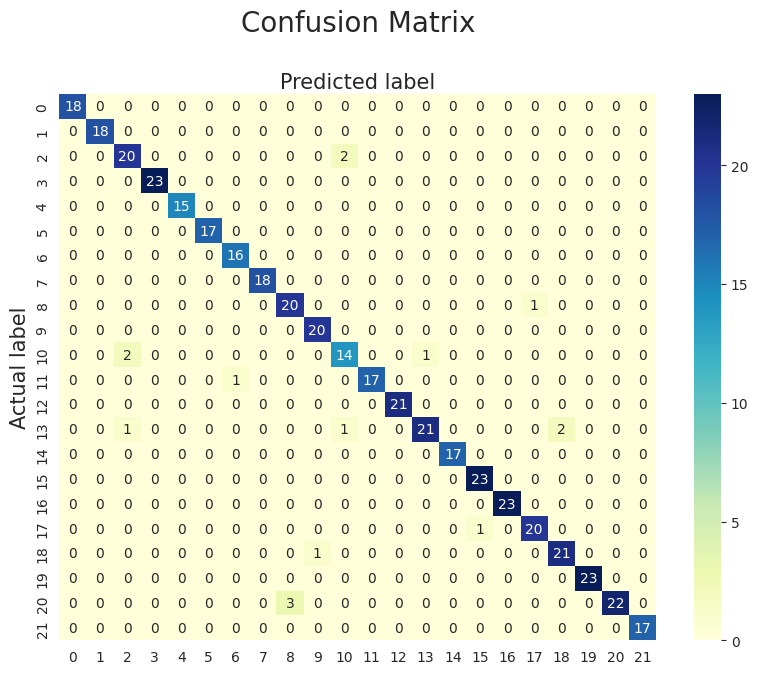

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        18
      banana       1.00      1.00      1.00        18
   blackgram       1.00      1.00      1.00        22
    chickpea       1.00      1.00      1.00        23
     coconut       1.00      1.00      1.00        15
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        16
      grapes       1.00      1.00      1.00        18
        jute       0.88      1.00      0.93        21
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      1.00      1.00        17
       maize       1.00      1.00      1.00        18
       mango       1.00      1.00      1.00        21
   mothbeans       1.00      1.00      1.00        25
    mungbean       1.00      1.00      1.00        17
   muskmelon       1.00      1.00      1.00        23
      orange       1.00      1.00      1.00        23
      papaya       1.00    

In [27]:
target = 'label'
X_train, X_test, y_train, y_test = read_in_and_split_data(dset, target)

pipeline4 = make_pipeline(StandardScaler(), LogisticRegression())
model4 = pipeline4.fit(X_train, y_train)
y_pred4 = model4.predict(X_test)
matrix4 = confusion_matrix(y_test, y_pred4)
classification_metrics(pipeline4, matrix4)

*KNeighborsClassifier*

Training Accuracy Score: 98.4%
Validation Accuracy Score: 97.7%


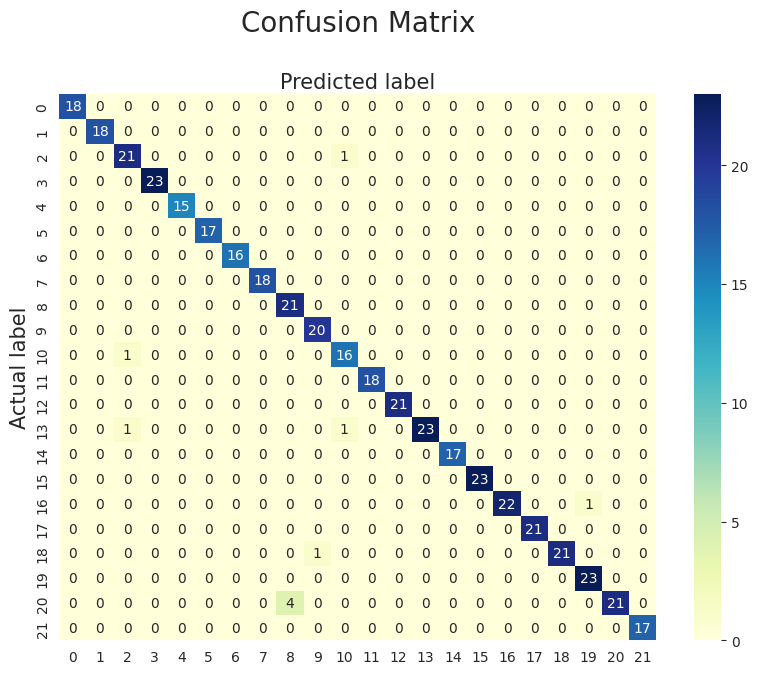

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        18
      banana       1.00      1.00      1.00        18
   blackgram       1.00      1.00      1.00        22
    chickpea       1.00      1.00      1.00        23
     coconut       1.00      1.00      1.00        15
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        16
      grapes       1.00      1.00      1.00        18
        jute       0.88      1.00      0.93        21
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      1.00      1.00        17
       maize       1.00      1.00      1.00        18
       mango       1.00      1.00      1.00        21
   mothbeans       1.00      1.00      1.00        25
    mungbean       1.00      1.00      1.00        17
   muskmelon       1.00      1.00      1.00        23
      orange       1.00      1.00      1.00        23
      papaya       1.00    

In [28]:
target = 'label'
X_train, X_test, y_train, y_test = read_in_and_split_data(dset, target)

pipeline5 = make_pipeline(StandardScaler(), KNeighborsClassifier())
model5 = pipeline5.fit(X_train, y_train)
y_pred5 = model5.predict(X_test)
matrix5 = confusion_matrix(y_test, y_pred5)
classification_metrics(pipeline5, matrix5)

*LinearDiscriminantAnalysis*

Training Accuracy Score: 97.0%
Validation Accuracy Score: 95.9%


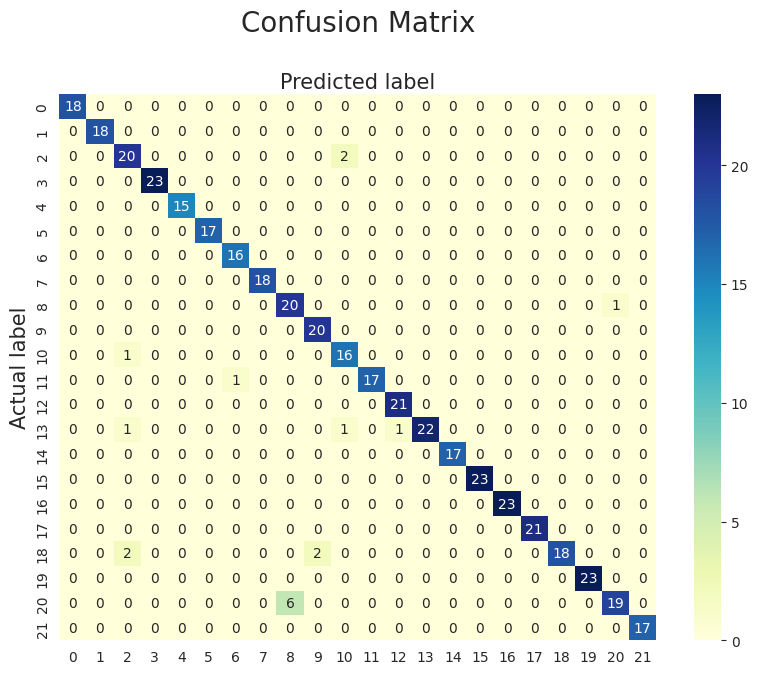

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        18
      banana       1.00      1.00      1.00        18
   blackgram       1.00      1.00      1.00        22
    chickpea       1.00      1.00      1.00        23
     coconut       1.00      1.00      1.00        15
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        16
      grapes       1.00      1.00      1.00        18
        jute       0.88      1.00      0.93        21
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      1.00      1.00        17
       maize       1.00      1.00      1.00        18
       mango       1.00      1.00      1.00        21
   mothbeans       1.00      1.00      1.00        25
    mungbean       1.00      1.00      1.00        17
   muskmelon       1.00      1.00      1.00        23
      orange       1.00      1.00      1.00        23
      papaya       1.00    

In [29]:
target = 'label'
X_train, X_test, y_train, y_test = read_in_and_split_data(dset, target)

pipeline6 = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())
model6 = pipeline6.fit(X_train, y_train)
y_pred6 = model6.predict(X_test)
matrix6 = confusion_matrix(y_test, y_pred6)
classification_metrics(pipeline6, matrix6)

# **Evaluating different ML models**

In [30]:
X_train, X_test, y_train, y_test = read_in_and_split_data(dset, target)

Models = GetModel()
fit_model(X_train, y_train, Models)

(['LR', 'LDA', 'KNN', 'DTreeC', 'NB', 'SVM'],
 [array([0.97727273, 0.96590909, 0.96590909, 0.96022727, 0.95454545,
         0.94318182, 0.96590909, 0.91477273, 0.96022727, 0.94318182]),
  array([0.95454545, 0.97727273, 0.98295455, 0.98295455, 0.95454545,
         0.95454545, 0.97727273, 0.96590909, 0.96590909, 0.94318182]),
  array([0.97159091, 0.97727273, 0.98295455, 0.97727273, 0.97727273,
         0.98863636, 0.98295455, 0.97159091, 0.98295455, 0.98295455]),
  array([0.98863636, 0.97727273, 0.97727273, 0.98863636, 0.99431818,
         0.96590909, 0.99431818, 0.97159091, 0.99431818, 0.98295455]),
  array([0.99431818, 0.98863636, 1.        , 1.        , 0.99431818,
         1.        , 0.98863636, 0.98863636, 0.99431818, 0.98863636]),
  array([0.97159091, 0.97727273, 0.97727273, 0.99431818, 0.96590909,
         0.98295455, 0.97727273, 0.96590909, 0.97159091, 0.98295455])])

**Save the model**

In [31]:
def save_model(model, filename):
    pickle.dump(model, open(filename, 'wb'))

In [32]:
save_model(model1, 'model_best.pkl') # 1st Best Model

In [33]:
save_model(model3, 'model_best_2nd.pkl') # 2nd Best Model

In [34]:
save_model(model2, 'model_best_3rd.pkl') # 3rd Best Model